# **Individual Report** #

#### Name: Alec Neme

#### Student Number: 84761030

#### Group 3

In [43]:
library(broom)
library(MASS)
library(glmbb)
library(cowplot)
library(tidyverse)
library(glmnet)
library(knitr)
library(caret)

## **Section 0: TA Feedback**
Good job!

Section 1: 

- Data description: Forgot to describe the type of variables? (Continuous or categorical?)
 It is better to include a link to data source so that it is easier for readers to follow along.

Section 2: Clear scientific question.

Section 3:

Visualization:
- The visualization isn’t sufficiently informative to provide insight for your research question.
- The plot only explores two variables.
Interpretation
- ‘Influence’ is a bit ambiguous and implies causality. I suggest using ‘associated with’ instead.

## **Section 1: Data Decription** 
The Dataset that will be explored is:
> Romero-Hernandez, O. (n.d.). Customer Personality Analysis [Data set]. Kaggle.
>
> https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

We begin by reading the dataset below into R. 


The dataset contains 2,240 observations total, and a total of 19 covariates. Here is the specification of each variable: 
### **People**
- **ID:** Customer's unique identifier (double)  
- **Year_Birth:** Customer's birth year (double)  
- **Education:** Customer's education level (factor)
- **Marital_Status:** Customer's marital status (factor)
- **Income:** Customer's yearly household income (double) 
- **Kidhome:** Number of children in customer's household (double)
- **Teenhome:** Number of teenagers in customer's household (double)
- **Dt_Customer:** Date of customer's enrollment with the company (date)  
- **Recency:** Number of days since customer's last purchase (double)
- **Complain:** 1 if the customer complained in the last 2 years, 0 otherwise (factor) 

### **Products**
- **MntWines:** Amount spent on wine in last 2 years (double)
- **MntFruits:** Amount spent on fruits in last 2 years (double)
- **MntMeatProducts:** Amount spent on meat in last 2 years (double)
- **MntFishProducts:** Amount spent on fish in last 2 years (double)
- **MntSweetProducts:** Amount spent on sweets in last 2 years (double)
- **MntGoldProds:** Amount spent on gold in last 2 years (double)

### **Promotion**
- **NumDealsPurchases:** Number of purchases made with a discount (double)
- **AcceptedCmp1:** 1 if customer accepted the offer in the 1st campaign, 0 otherwise (factor)
- **AcceptedCmp2:** 1 if customer accepted the offer in the 2nd campaign, 0 otherwise (factor)  
- **AcceptedCmp3:** 1 if customer accepted the offer in the 3rd campaign, 0 otherwise (factor) 
- **AcceptedCmp4:** 1 if customer accepted the offer in the 4th campaign, 0 otherwise (factor) 
- **AcceptedCmp5:** 1 if customer accepted the offer in the 5th campaign, 0 otherwise (factor) 
- **Response:** 1 if customer accepted the offer in the last campaign, 0 otherwise (factor) 

### **Place**
- **NumWebPurchases:** Number of purchases made through the company’s website (double)
- **NumCatalogPurchases:** Number of purchases made using a catalogue (double)  
- **NumStorePurchases:** Number of purchases made directly in stores (double) 
- **NumWebVisitsMonth:** Number of visits to company’s website in the last month (double)

### **Collection method** 
Data was collected from a marketing campaign conducted by a company to profile customers based on demographic and behavioral information (e.g., spending habits, responses to campaigns).

### **Variables to keep** 
The variables that seem useless are, and thus I will drop them:  
- ID (identifier, not useful for analysis)
- Dt_Customer (date variable can be transformed into “years as customer” instead)
- Z_CostContact, Z_Revenue (constants), and no variable specification. Since they're constant they will confound results and estimates.

## **Section 2: Data Description** 
- The main question this project aims to answer is: Can we predict whether a customer will accept the company’s next marketing campaign using their demographic, lifestyle, and purchasing characteristics?
- The response variable is Response, which indicates whether a customer accepted the most recent marketing campaign (1 = Yes, 0 = No).
- The predictors include all available variables in the dataset, such as demographic features (age, income, education, marital status), household composition (number of children and teenagers), purchasing behavior (amount spent across different product categories), and previous campaign responses.
- The focus of this project is prediction, as the goal is to build a model that can estimate the probability of a customer accepting a future campaign.
- Nonetheless, analyzing which predictors contribute most to accurate predictions may also provide insightful interpretive findings for marketing strategy.
- From there on, model selection to minimize risk will be done. 

## **Section 3: Exploratory Data Analysis and Visualization** 

In [4]:
customer_personality <- read_tsv("marketing_campaign.csv")

customer_personality_clean <- customer_personality %>%
  # Drop useless variables
  select(-ID, -Dt_Customer, -Z_CostContact, -Z_Revenue) %>%
  # Create derived features
  mutate(Age = 2025 - Year_Birth,
         Total_Spending = MntWines + MntFruits + MntMeatProducts +
                     MntFishProducts + MntSweetProducts + MntGoldProds,
         # Convert categorical and binary variables to factors
         Education = as.factor(Education),
         Marital_Status = as.factor(Marital_Status),
         Complain = as.factor(Complain),
         AcceptedCmp1 = as.factor(AcceptedCmp1),
         AcceptedCmp2 = as.factor(AcceptedCmp2),
         AcceptedCmp3 = as.factor(AcceptedCmp3),
         AcceptedCmp4 = as.factor(AcceptedCmp4),
         AcceptedCmp5 = as.factor(AcceptedCmp5),
         Response = as.factor(Response)) %>%
  # Drop any rows with missing data (safe for GLM later)
  drop_na()

head(customer_personality_clean)

Rows: 2240 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): Education, Marital_Status, Dt_Customer
dbl (26): ID, Year_Birth, Income, Kidhome, Teenhome, Recency, MntWines, MntF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,⋯,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Total_Spending
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1957,Graduation,Single,58138,0,0,58,635,88,546,⋯,7,0,0,0,0,0,0,1,68,1617
1954,Graduation,Single,46344,1,1,38,11,1,6,⋯,5,0,0,0,0,0,0,0,71,27
1965,Graduation,Together,71613,0,0,26,426,49,127,⋯,4,0,0,0,0,0,0,0,60,776
1984,Graduation,Together,26646,1,0,26,11,4,20,⋯,6,0,0,0,0,0,0,0,41,53
1981,PhD,Married,58293,1,0,94,173,43,118,⋯,5,0,0,0,0,0,0,0,44,422
1967,Master,Together,62513,0,1,16,520,42,98,⋯,6,0,0,0,0,0,0,0,58,716


Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”


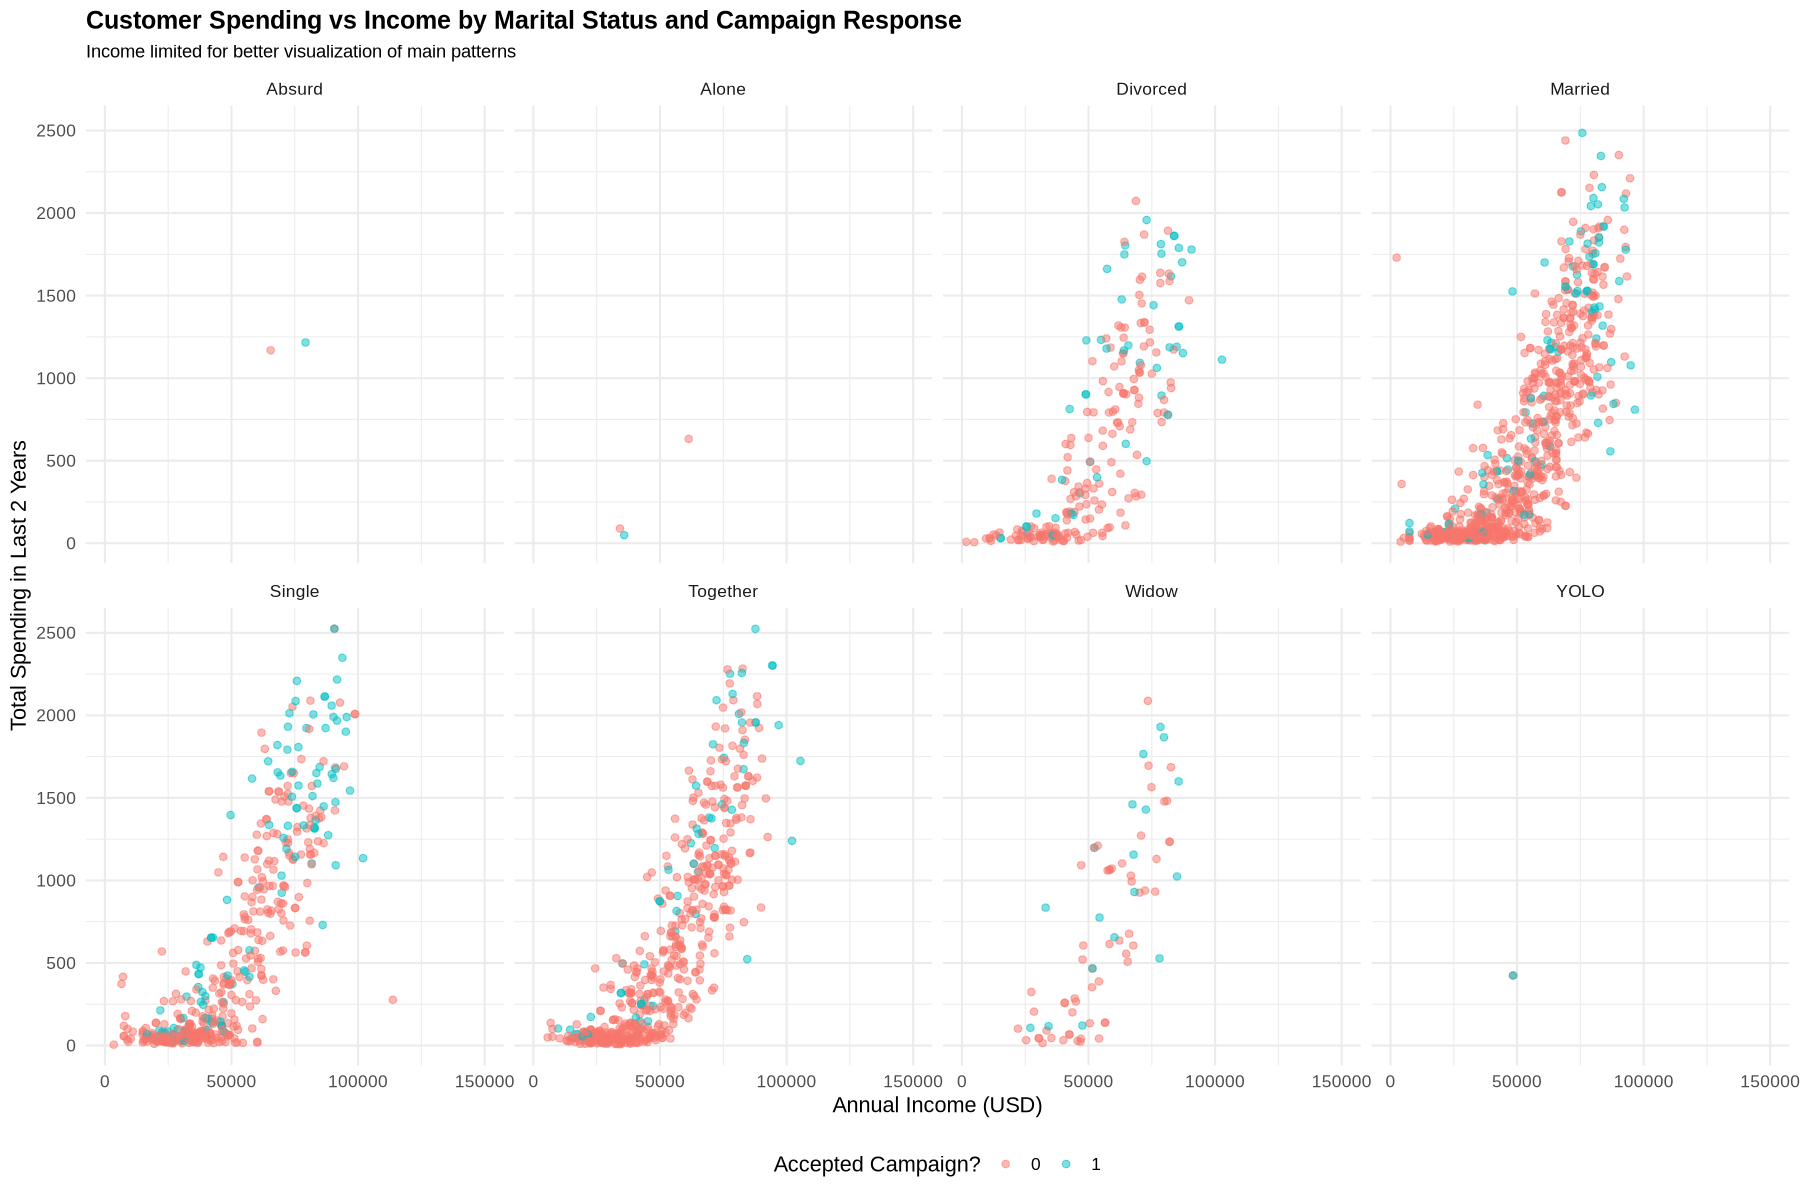

In [42]:
options(repr.plot.width = 15, repr.plot.height = 10)

ggplot(customer_personality_clean,
       aes(x = Income, y = Total_Spending, color = Response)) +
  geom_point(alpha = 0.5, size = 1.8) +
  facet_wrap(~ Marital_Status, nrow = 2) +
  xlim(0, 150000) +  # <-- LIMIT THE X-AXIS (adjust if needed)
  labs(
    title = "Customer Spending vs Income by Marital Status and Campaign Response",
    subtitle = "Income limited for better visualization of main patterns",
    x = "Annual Income (USD)",
    y = "Total Spending in Last 2 Years",
    color = "Accepted Campaign?"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", size = 15),
    plot.subtitle = element_text(size = 11),
    legend.position = "bottom"
  )


### **Why this plot is relevant**
- The goal of the analysis is to predict whether a customer will accept the next marketing campaign (Response).
- Marital Status, Annual Income, and Total Spending in the last 2 years are demographic predictors that may be <mark>associated with</mark> purchasing or decision-making behaviour.

### **Interpretation of the results**
- <mark>The plot shows that acceptance rates vary by marital status.
- <mark>Across several marital groups (particularly Married, Together, and Single), customers who accepted the campaign (Response = 1) tend to show higher overall spending, especially at moderate to higher income levels.
- <mark>Some marital categories (e.g., Absurd and YOLO) have very few observations, which might reduce their predictive value, while larger groups like Married and Together show clearer trends
- <mark>There is no single linear pattern across all groups, suggesting that interactions between predictors (e.g., between income and marital status) may improve predictive performance.</mark>

### **What we learn**
- <mark>Spending behavior and income appear to be meaningful predictors of campaign response, but their effects differ across marital groups.
- The visualization supports the idea that customer segmentation may help improve prediction, as different marital groups show distinct response patterns.
- This early exploration helps guide which predictors to keep when building a logistic regression model.

## **Section 4: Method and Plan** 

### **Proposed Method**
- I plan to use Ridge Logistic Regression to predict whether a customer will accept the next marketing campaign (Response = 0 or 1).

### **Why is this method appropriate?**
- Since I have chosen to keep all predictors, regularization is a good idea to deal with any multicollinearity and possible overfitting.
- Ridge Regression uses interpretability of the model, but it is often a better predictor than a simple logistic regression.

### **Required assumptions:**
- Ridge assumes a linear relationship between predictors and the log-odds of the response and that observations are independent.

### **Potential limitations:**
- Ridge regression shrinks coefficients toward zero, which makes interpretation more difficult compared to a standard logistic model.
- The relationship between predictors and the response may not be strictly linear on the log-odds scale.



## **Section 5: Computational Code and Output** 

In [1]:
set.seed(123)

n <- nrow(customer_personality_clean)
train_size <- floor(0.7 * n)      # 70% train, 30% test

train_index <- sample(seq_len(n), size = train_size)

train_data <- customer_personality_clean[train_index, ]
test_data  <- customer_personality_clean[-train_index, ]


x_train <- model.matrix(Response ~ ., data = train_data)[, -1]  
y_train <- as.numeric(as.character(train_data$Response))       

x_test  <- model.matrix(Response ~ ., data = test_data)[, -1]
y_test  <- as.numeric(as.character(test_data$Response)) 

cv_ridge <- cv.glmnet(x_train, y_train, alpha = 0, family = "binomial", nfolds = 10)

best_lambda <- cv_ridge$lambda.min
se_lambda <- cv_ridge$lambda.1se

final_ridge_model <- glmnet(
  x_train, y_train,
  alpha = 0,         
  lambda = best_lambda,    
  family = "binomial"
)

pred_prob <- predict(final_ridge_model, newx = x_test, type = "response")

pred_class <- ifelse(pred_prob >= 0.5, 1, 0)

conf_matrix <- confusionMatrix(
  data      = as.factor(pred_class),   
  reference = as.factor(y_test),       
  positive  = "1"                      
)

cm_counts <- conf_matrix$table

cm_table <- as.data.frame.matrix(cm_counts)

rownames(cm_table) <- paste0("Predicted = ", rownames(cm_table))
colnames(cm_table) <- paste0("Actual = ", colnames(cm_table))

byclass_metrics <- data.frame(
  Metric = names(conf_matrix$byClass),
  Value  = as.numeric(conf_matrix$byClass),
  row.names = NULL
)

accuracy <- as.numeric(conf_matrix$overall["Accuracy"])
misclass_rate <- 1 - accuracy

byclass_metrics <- rbind(
  byclass_metrics,
  data.frame(Metric = "Accuracy", Value = accuracy),
  data.frame(Metric = "Misclassification Rate", Value = misclass_rate)
)

byclass_metrics$Value <- round(byclass_metrics$Value, 3)

cat("### Table 1: Classification Metrics (Positive Class = 1)\n")
byclass_metrics

ERROR: Error in eval(expr, envir, enclos): object 'customer_personality_clean' not found


- The ridge logistic regression model achieved an accuracy of 89.2%, which is higher than the No Information Rate (85.7%), suggesting that the model performs better than random guessing.
- The model shows high specificity (0.99), meaning it correctly identifies customers who did not accept the campaign, but sensitivity is lower (0.32), indicating difficulty detecting actual responders.
- The positive predictive value (0.81) suggests that when the model predicts a customer will accept the campaign, it is correct most of the time.
- This indicates that the model is more reliable at identifying non-responders but could be improved for detecting responders, possibly by adjusting the prediction threshold, incorporating interactions, or testing alternative models such as lasso or tree-based methods.